#### Anomaly Detection - Imports and Setup

In [22]:
%reload_ext autoreload
%autoreload 2
import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.callbacks  import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Lambda, Dropout, SimpleRNN, Dense, LSTM, RepeatVector, Input, TimeDistributed, concatenate
from keras import regularizers
from keras.utils import plot_model

import IPython, IPython.display, os, datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ts_utils
import ts_plot_utils

mpl.rcParams['figure.figsize'] = (14, 4)
mpl.rcParams['axes.grid'] = True

print(f"Tensorflow Version {tf.__version__}, Keras Vesion: {keras.__version__}")


Tensorflow Version 2.10.0, Keras Vesion: 2.10.0


In [3]:
# Read the data
df, df_scaled_trn, df_scaled_tst, scaler = ts_utils.load_file()
print("Training Data:")
display(df_scaled_trn)

input_slice  = slice(0,30000)
label_slice  = slice(0,3)
window_len   = 24
ouput_len    = 1
batch_size   = 20

ouput_feat_len  = label_slice.stop - (label_slice.start or 0)
model_op_len    = ouput_feat_len * ouput_len

ds_trn = tf.data.Dataset.from_tensor_slices(df_scaled_trn[df_scaled_trn.columns[input_slice]])
ds_tst = tf.data.Dataset.from_tensor_slices(df_scaled_tst[df_scaled_trn.columns[input_slice]])
window_trn = ts_utils.window(ds_trn, window_len, ouput_len, label_slice, batch_size=batch_size, skip=0)
window_tst = ts_utils.window(ds_tst, window_len, ouput_len, label_slice, batch_size=batch_size, skip=0)

window_trn100 = ts_utils.window(ds_trn, window_len, ouput_len, label_slice, batch_size=100000, skip=0)
window_tst100 = ts_utils.window(ds_tst, window_len, ouput_len, label_slice, batch_size=100000, skip=0)

inp_feat_len = ds_trn.element_spec.shape[0]

Training Data:


/Users/e346104/venv/py3.9/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Day sin,Day cos,Year sin,Year cos
0,0.918199,-2.018473,-2.075600,-1.951683,1.102658,-1.315794,-1.483534,-0.788226,-1.485852,-1.488569,2.246640,-1.257984,-1.252731,0.214456,0.366058,1.366366,-0.049590,1.401955
1,0.932570,-2.116803,-2.174215,-2.096616,1.029922,-1.343873,-1.541361,-0.783947,-1.542786,-1.545690,2.356037,-1.232044,-1.252731,0.186889,0.707152,1.225091,-0.048581,1.401945
2,0.958917,-2.108510,-2.168345,-2.080512,1.048106,-1.342536,-1.534133,-0.786086,-1.535194,-1.538550,2.354292,-1.277439,-1.252731,-0.078439,1.000057,1.000355,-0.047571,1.401933
3,0.976881,-2.136943,-2.197695,-2.133215,0.993555,-1.350558,-1.553409,-0.779667,-1.554173,-1.559970,2.389927,-1.329318,-1.359684,0.757747,1.224811,0.707473,-0.046562,1.401921
4,1.033168,-2.205656,-2.270482,-2.225446,0.969309,-1.367941,-1.587141,-0.779667,-1.588333,-1.593290,2.479139,-1.134770,-1.145779,-0.195597,1.366097,0.366405,-0.045552,1.401908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56067,0.372099,0.968172,0.930989,0.772772,-0.861203,0.859638,0.687395,0.765285,0.677648,0.677237,-0.821697,0.551316,0.445669,-1.621823,-0.707116,-1.224304,0.811018,-1.136631
56068,0.321800,1.040439,1.007298,0.693717,-1.132749,0.962593,0.583788,1.024204,0.571371,0.574897,-0.891223,-0.823493,-0.546847,-0.857195,-1.000021,-0.999567,0.810227,-1.137265
56069,0.254736,1.233546,1.204528,0.661510,-1.517642,1.255414,0.542827,1.529202,0.533415,0.534437,-1.069895,-0.992101,-0.940431,-0.356402,-1.224775,-0.706686,0.809435,-1.137897
56070,0.206832,1.189712,1.164613,0.657118,-1.452180,1.187223,0.535599,1.424350,0.529619,0.529677,-1.044478,-0.881857,-0.940431,0.264994,-1.366061,-0.365618,0.808642,-1.138529


2023-01-27 21:26:09.788195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### What is Repeat Vector Layer

>>
```
    RepeatVector(n)
```

RepeatVector layer simply repeats the provided 2D input n times to create 3D output.
See the example below

```
>>>  RepeatVector(4)(np.array([[1,1]]))

<tf.Tensor: shape=(1, 4, 2), dtype=int64, numpy=
array([[[1, 1],
        [1, 1],
        [1, 1],
        [1, 1]]])>
```


In [4]:
RepeatVector(4)(np.array([[1,1]]))

<tf.Tensor: shape=(1, 4, 2), dtype=int64, numpy=
array([[[1, 1],
        [1, 1],
        [1, 1],
        [1, 1]]])>

In [91]:
inputs = np.random.random([32, 10, 8]).astype(np.float32)
simple_rnn = tf.keras.layers.SimpleRNN(4)
m = Sequential([simple_rnn])
output = simple_rnn(inputs)  # The output has shape `[32, 4]`.
#TimeDistributed()
simple_rnn.weights
m.compile()
m(inputs)
m.summary(), m.weights

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (32, 4)                   52        
                                                                 
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


(None,
 [<tf.Variable 'simple_rnn_8/simple_rnn_cell_8/kernel:0' shape=(8, 4) dtype=float32, numpy=
  array([[ 0.06976789,  0.2194708 , -0.0300554 , -0.64344597],
         [-0.5126348 ,  0.5857275 ,  0.6093176 ,  0.7040419 ],
         [ 0.4726823 ,  0.5867619 , -0.18807173,  0.5490168 ],
         [-0.26496983, -0.18372113,  0.70496625, -0.696082  ],
         [-0.48925292, -0.47235084,  0.11122251,  0.24441803],
         [-0.21667612,  0.62543577,  0.2716425 , -0.610428  ],
         [ 0.35713655,  0.20868438,  0.06967312, -0.68533   ],
         [-0.49230248, -0.01159799,  0.30998117,  0.6974047 ]],
        dtype=float32)>,
  <tf.Variable 'simple_rnn_8/simple_rnn_cell_8/recurrent_kernel:0' shape=(4, 4) dtype=float32, numpy=
  array([[-0.16864169, -0.10589879, -0.8825944 , -0.42587876],
         [ 0.19290856,  0.71233934, -0.38854945,  0.551714  ],
         [-0.9171714 , -0.06068241, -0.00747859,  0.3937744 ],
         [ 0.30519313, -0.691141  , -0.26457638,  0.59931684]],
        dtype=fl

### Create and Compile Models

In [46]:
inp_feat_len = ds_trn.element_spec.shape[0]

performance = {}
models = []

dim = 128

# Create Autoencoder Layer
input_layer = Input(shape=(window_len, inp_feat_len), dtype='float32', name='input')
memory_layer = LSTM(dim, return_sequences=True)(input_layer)
memory_layer = LSTM (int(dim//2), return_sequences=False)(memory_layer)
repeated_lyr = RepeatVector(window_len)(memory_layer)
memory_layer = LSTM (int(dim//2), return_sequences=True)(repeated_lyr)
memory_layer = LSTM (dim,  return_sequences=True)(memory_layer)
decoded_inputs = TimeDistributed(Dense(units=inp_feat_len, activation='linear'))( memory_layer)

dropout_input = Dropout(0.2)(input_layer)
concat_layer = concatenate([dropout_input, decoded_inputs])
memory_layer = LSTM(units=dim, 
                    kernel_regularizer = regularizers.l1_l2(l1= .1, l2= .1), 
                    recurrent_regularizer = regularizers.l1_l2(l1= .1, l2= .1), 
                    return_sequences=False)(concat_layer)
preds = Dense(units=inp_feat_len, activation='linear')(memory_layer)

umodel = Model(input_layer, preds)
#umodel.summary()

models.append(umodel)

In [47]:

# LSTM Model
lstm_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].

        tf.keras.layers.LSTM(64, return_sequences=False)
    ]+ ts_utils.getCommonLayer(ouput_len, ouput_feat_len),
    name = "LSTM"
)
models.append(lstm_model)

700/700 [==============================] - 1s 1ms/step - loss: 0.0062 - mean_absolute_error: 0.0567


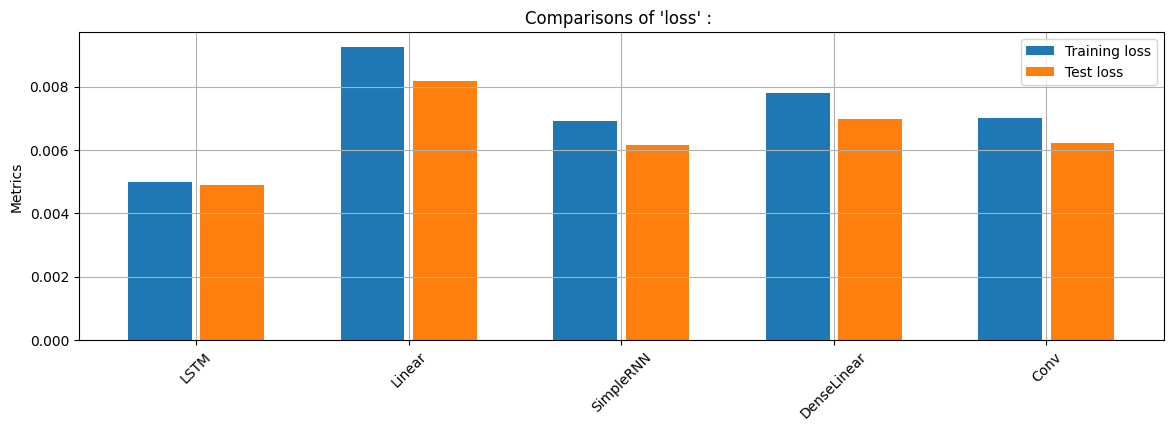

In [11]:
for i, model in enumerate(models):
    print(f"Now Compiling {i+1}/{len(models)} {model.name} ")
    history = ts_utils.compile_fit(model, window_trn, window_tst, epochs=10, verbose=1)
    IPython.display.clear_output()

# Plot graphs
performance = ts_plot_utils.plot_performance(models, window_trn, window_tst, performance=performance)

### Predictions

In [48]:
#model = lstm_model
#ydf, pdf = ts_plot_utils.predict_and_plot( model, window_trn100, window_tst100, howmany=1024* 1024,
#                        plot_start=-200, df=None, scaler=None, label_slice=None)
#;

### The END